In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats
import requests
from io import StringIO
import csv

# Graph of sales by product

In [4]:
def getData(data_name: str):
    response = requests.get(f"http://127.0.0.1:8000/{data_name}")

    # Check if the request was successful (status code 200)
    if response.status_code == 200:

        # Create a CSV writer
        output_csv = StringIO()
        csv_writer = csv.writer(output_csv)

        # Split input string into lines and write them to the CSV
        for line in response.text.split('\\n'):
            csv_writer.writerow(line.split(','))

        # Get the CSV content as a string
        csv_content = output_csv.getvalue().replace('\\"' , '').replace('","', '#').replace('"', '')

        # Close the StringIO object
        output_csv.close()

        df = pd.read_csv(StringIO(csv_content))

        return df
    else:
        return pd.DataFrame()

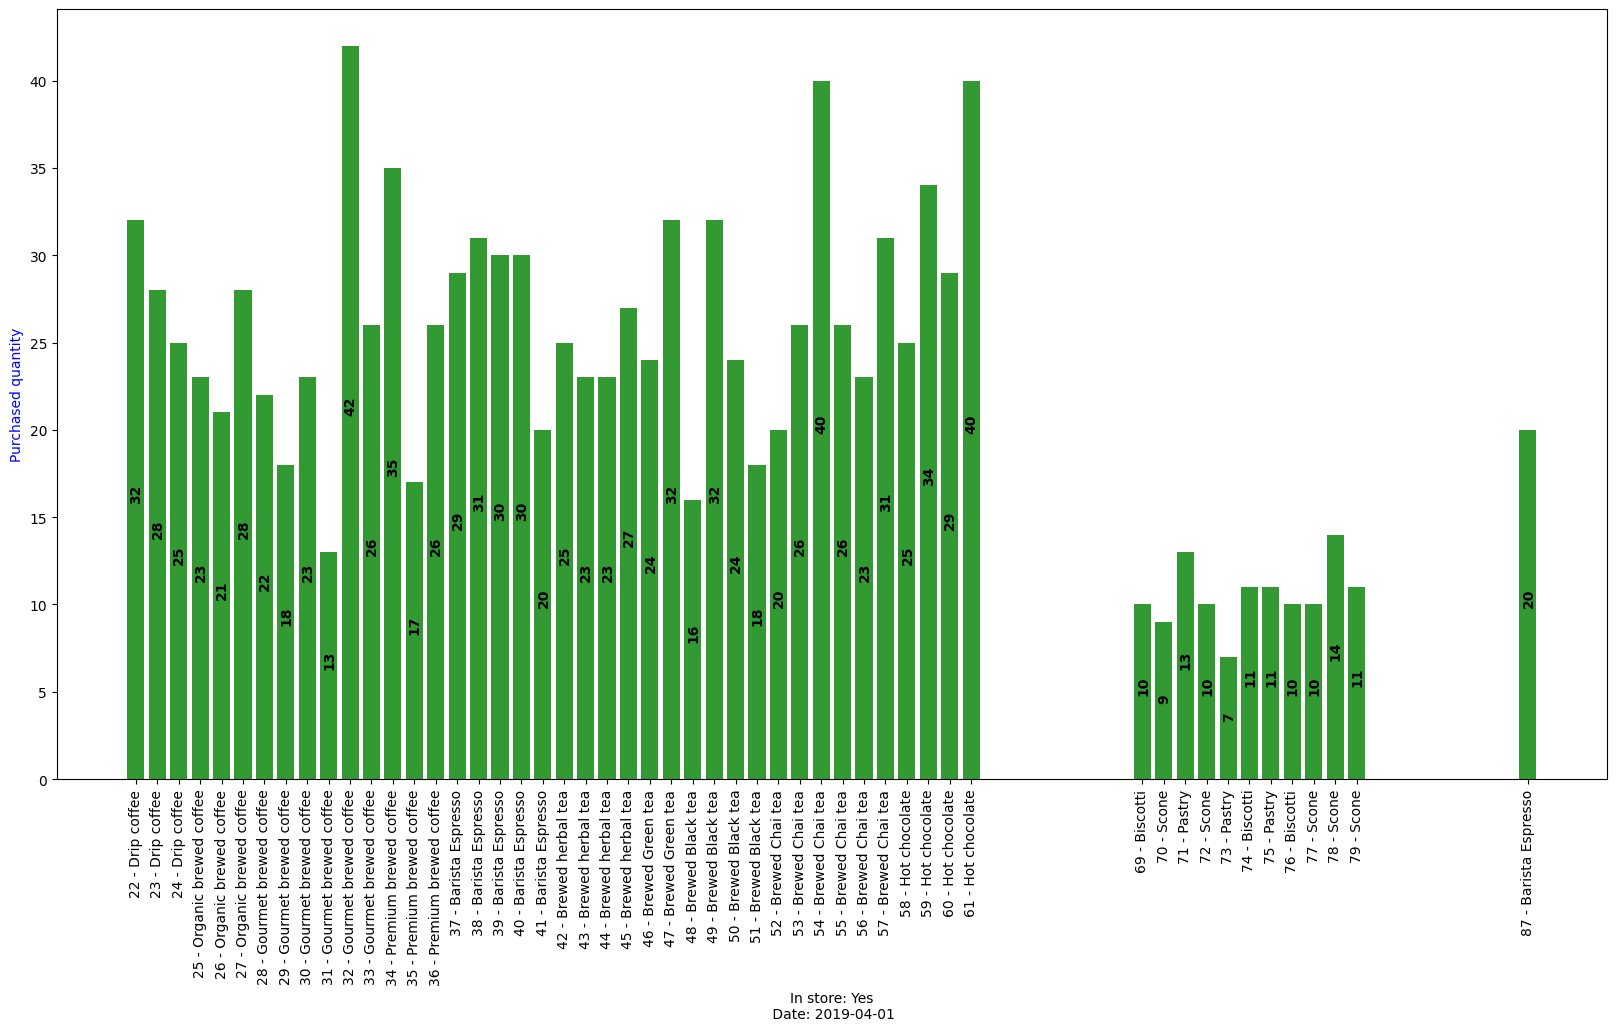

In [6]:
# products = pd.read_csv("../app/data/product.csv", delimiter=",")
products = getData('product')
products = products[['product_id', 'product_group', 'product_category', 'product_type', 'product']]

# customers = pd.read_csv("../app/data/customer.csv", delimiter=",")
customers = getData('customers')
customers = customers[['customer_id', 'gender', 'birth_year']]

# sales_reciepts = pd.read_csv("../app/data/sales_reciepts.csv", delimiter=",")
sales_reciepts = getData('sales_reciepts')

specific_date = '2019-04-01' # Filtering for Date
specific_instore = 'Y' # Filtering for Instore

sales_reciepts_final = sales_reciepts.loc[
    (sales_reciepts['transaction_date'].str.contains(specific_date)) &
    (sales_reciepts['instore_yn'] == specific_instore)
]

filtered_sales = sales_reciepts_final[['product_id', 'transaction_date', 'customer_id', 'quantity']]
sales_reciepts_grouped = filtered_sales.groupby('product_id')['quantity'].sum().reset_index()
sales_reciepts_final = pd.merge(sales_reciepts_grouped, products, on='product_id', how='left')
sales_reciepts_final.sort_values(by="product_id", ascending=False)

highest_product_id = sales_reciepts_final['product_id'].max()
lowest_product_id = sales_reciepts_final['product_id'].min()

bar_x_labels = []; # Labels for X axis
for id, product in zip(sales_reciepts_final['product_id'], sales_reciepts_final['product_type']):
    bar_x_labels.append(f"{id} - {product}")

fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(sales_reciepts_final['product_id'], sales_reciepts_final['quantity'], color=(0.2, 0.6, 0.2, 1))
plt.xticks(sales_reciepts_final['product_id'], bar_x_labels, rotation=90)

ax.set_xlabel(f"In store: {'No' if specific_instore == 'N' else 'Yes'}\n Date: {specific_date}")
ax.set_ylabel("Purchased quantity", color='blue')

for id, quan in zip(sales_reciepts_final['product_id'], sales_reciepts_final['quantity']):
    ax.text(id - .30, quan / 2, str(quan), color='black', fontweight='bold', rotation=90)